<a href="https://colab.research.google.com/github/patriciamedyna/Classifier_page/blob/main/ULMFiT_notfirstpage_victor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! [ -e /content ] && pip install -Uqq fastai

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.0 MB/s eta 0:00:00


In [ ]:
!pip install nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
#hide
from fastbook import *
from IPython.display import display,HTML

In [ ]:
from fastai.basics import *
from fastai.text.core import *
from fastai.text.data import *
from fastai.text.models.core import *
from fastai.text.models.awdlstm import *
from fastai.callback.rnn import *
from fastai.callback.progress import *
from fastai.vision import *
from fastai.text.all import *
from fastai.text import *
from datetime import datetime

In [ ]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [ ]:
warnings.filterwarnings(action='ignore')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss, zero_one_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/small_victor/'

In [ ]:
df_train = pd.read_csv(path + 'train/df_train_notfirst.csv', delimiter=',',  error_bad_lines=False, index_col=False)
df_train.tail(1)

,page,text,label,is_valid
119491,2,"\n\n \n\nCERTIDÃO\n\nCertifico e dou fé que me dirigi ao Setor de Autarquias Sul, Quadra 3,\nLotes 5/6, Edifício Multi Brasil Corporate, 7º andar, nesta data, e, às\n16h30min, procedi à INTIMAÇÃO da PROCURADORIA-GERAL\nFEDERAL, na pessoa da Procuradora Federal RENATA DE CARVALHO\nACCIOLY LIMA, que recebeu a contrafé e apôs seu ciente no anverso\n\ndeste mandado.\n\nBrasília, 07 de novembro de 2016.\n\n|\n\nFERNANDO DE SOUS ALE\nOficial de Justiça F al\n\n \n\n \n",outros,False


In [ ]:
#missing = df_train.isnull().sum()
#print(missing)

In [ ]:
#df_train['text'].fillna('xxP001', inplace = True)

In [ ]:
df_train_tags = pd.read_csv(path + 'train/df_train_tags_notfirst.csv', delimiter=',',  error_bad_lines=False, index_col=False)
df_train_tags.tail(1)

,page,label,text,is_valid
119491,2,outros,"['\nxxP002\nxxQ00_00 xxbob \nxxeob xxQ00_04\n\nxxP002\nxxQ00_00 xxbob \nxxeob xxQ01_00\n\nxxP002\nxxQ00_01 xxbob CERTIDÃO\nxxeob xxQ00_02\n\nxxP002\nxxQ00_00 xxbob Certifico e dou fé que me dirigi ao Setor de Autarquias Sul, Quadra 3,\nLotes 5/6, Edifício Multi Brasil Corporate, 7º andar, nesta data, e, às\n16h30min, procedi à INTIMAÇÃO da PROCURADORIA-GERAL\nFEDERAL, na pessoa da Procuradora Federal RENATA DE CARVALHO\nACCIOLY LIMA, que recebeu a contrafé e apôs seu ciente no anverso\nxxeob xxQ01_03\n\nxxP002\nxxQ01_00 xxbob deste mandado.\nxxeob xxQ01_01\n\nxxP002\nxxQ01_00 xxbob Brasí...",False


In [ ]:
#missing = df_train_tags.isnull().sum()
#print(missing)

In [ ]:
df_train_tags.shape

(119492, 4)

In [ ]:
#df_train_nf.to_csv(path + 'train/df_train_tags_notfirst.csv', index=False)

In [ ]:
df_train.label.value_counts(), df_train.shape, df_train_tags.label.value_counts(), df_train_tags.shape


(outros                              103672
 peticao_do_RE                         9731
 agravo_em_recurso_extraordinario      3954
 sentenca                              1757
 acordao_de_2_instancia                 282
 despacho_de_admissibilidade             96
 Name: label, dtype: int64,
 (119492, 4),
 outros                              103672
 peticao_do_RE                         9731
 agravo_em_recurso_extraordinario      3954
 sentenca                              1757
 acordao_de_2_instancia                 282
 despacho_de_admissibilidade             96
 Name: label, dtype: int64,
 (119492, 4))

In [ ]:
df_test = pd.read_csv(path + 'test/df_test_notfirst.csv', delimiter=',', error_bad_lines=False, index_col=False)
df_test.tail(1)

,file,page,text,label
73274,RE_980600_310183925_80_25082016,2,"CERTIDÃO\n\nCertifico que me dirigi ao Setor de Autarquias Sul, Quadra 3, Lotes 5/6,\nEdifício Multi Brasil Corporate, 7º andar, nesta data e, às 13h00min,\nprocedi à INTIMAÇÃO da PROCURADORIA-GERAL FEDERAL, na\npessoa da Procuradora Federal HELOISA MARIA GOMES PEREIRA, que\n\nrecebeu a contrafé e apôs seu ciente no anverso deste mandado.\n\n \n\nciente.\n\nBrasília, 24 de agosto de 2016. — (3>\n\n \n\nSEDEUR FERN P\nOficial de Jusr ça Federal\n\n/ Í\n",outros


In [ ]:
missing = df_test.isnull().sum()
print(missing)

file     0
page     0
text     0
label    0
dtype: int64


In [ ]:
df_test.shape

(73275, 4)

In [ ]:
df_test_tags = pd.read_csv(path + 'test/df_test_tags_notfirst.csv', delimiter=',', error_bad_lines=False, index_col=False)
df_test_tags.tail(1)

,page,label,text
73274,2,outros,"[""\nxxP001\nxxQ00_03 xxbob ciente eM\nxxeob xxQ00_03\n\nxxP001\nxxQ00_03 xxbob 24 869 703\nxxeob xxQ00_03\n\nxxP001\nxxQ00_03 xxbob \n \nxxeob xxQ01_03\n\nxxP001\nxxQ00_01 xxbob xxbcet xxecet\nxxeob xxQ00_02\n\nxxP001\nxxQ00_01 xxbob xxbcet '—“%// xremo Tribanal Fodesal xxecet\nxxeob xxQ00_02\n\nxxP001\nxxQ01_00 xxbob WT\nxxeob xxQ01_01\n\nxxP001\nxxQ01_00 xxbob - E) MIet. SA\n(Seção De Recursos Extraordinários\nnº 10539/2016\nxxeob xxQ01_03\n\nxxP001\nxxQ01_01 xxbob \nxxeob xxQ01_01\n\nxxP001\nxxQ01_01 xxbob MANDADO DE INTIMAÇÃO\nxxeob xxQ01_02\n\nxxP001\nxxQ01_00 xxbob De ordem, o..."


In [ ]:
df_test_tags.shape

(73275, 3)

In [ ]:
df_test.label.value_counts(), df_test.shape, df_test_tags.label.value_counts(), df_test_tags.shape

(outros                              63709
 peticao_do_RE                        5876
 agravo_em_recurso_extraordinario     2334
 sentenca                             1216
 acordao_de_2_instancia                 88
 despacho_de_admissibilidade            52
 Name: label, dtype: int64,
 (73275, 4),
 outros                              63709
 peticao_do_RE                        5876
 agravo_em_recurso_extraordinario     2334
 sentenca                             1216
 acordao_de_2_instancia                 88
 despacho_de_admissibilidade            52
 Name: label, dtype: int64,
 (73275, 3))

In [ ]:
df_val = pd.read_csv(path + 'val/df_val_notfirst.csv', delimiter=',', error_bad_lines=False, index_col=False)
df_val.tail(1)

,page,text,label
77510,2,"Brasília, 08 de julho de 2016\n\nCoordenadoria de Processamento Inicial\n(documento eletrônico)\n\nCertidão gerada em 08/07/2016 às 18:12:07.\n\nEsta certidão pode ser validada em https://www.stf jus. br/portal/autenticacao/autenticarDocumento.asp com o seguinte código CEQ42MWXDOW.\n",outros


In [ ]:
df_val.shape

(77511, 3)

In [ ]:
df_val_tags = pd.read_csv(path + 'val/df_val_tags_notfirst.csv', delimiter=',', error_bad_lines=False, index_col=False)
df_val_tags.head(1)

,page,label,text,is_valid
0,2,outros,"['\nxxP001\nxxQ00_03 xxbob E\nxxeob xxQ00_04\n\nxxP001\nxxQ00_03 xxbob 2\nE\nxxeob xxQ00_04\n\nxxP001\nxxQ00_02 xxbob Sera Cj\nIA JUDICIÁRIA FLS. 0166 -\nxxeob xxQ00_03\n\nxxP001\nxxQ00_00 xxbob Pad\nmm o am alo,\n. <\nmm -. ———— mm Secrelafra”\nxxeob xxQ00_04\n\nxxP001\nxxQ00_00 xxbob \n \n \nxxeob xxQ00_04\n\nxxP001\nxxQ00_02 xxbob \nxxeob xxQ00_04\n\nxxP001\nxxQ00_00 xxbob \nxxeob xxQ00_03\n\nxxP001\nxxQ00_03 xxbob do Rã\nxxeob xxQ00_03\n\nxxP001\nxxQ00_00 xxbob \nxxeob xxQ00_01\n\nxxP001\nxxQ00_00 xxbob = AGRAVO INTERNO na APELAÇÃO CÍVEL n. 2009.003876\n— 9 / 0001.00, de RIO BRA...",True


In [ ]:
df_val.label.value_counts(), df_val.shape, df_val_tags.label.value_counts(), df_val_tags.shape,

(outros                              67110
 peticao_do_RE                        6486
 agravo_em_recurso_extraordinario     2423
 sentenca                             1336
 acordao_de_2_instancia                116
 despacho_de_admissibilidade            40
 Name: label, dtype: int64,
 (77511, 3),
 outros                              67110
 peticao_do_RE                        6486
 agravo_em_recurso_extraordinario     2423
 sentenca                             1336
 acordao_de_2_instancia                116
 despacho_de_admissibilidade            40
 Name: label, dtype: int64,
 (77511, 4))

In [ ]:
df_train.shape, df_test.shape, df_val.shape

((119492, 4), (73275, 4), (77511, 3))

In [ ]:
df = pd.concat([df_train, df_val], ignore_index = True)

In [ ]:
df_tags = pd.concat([df_train_tags, df_val_tags], ignore_index = True)

In [ ]:
df.to_csv(path + 'train/df_tags_first.csv', index=False)

In [ ]:
df_tags.to_csv(path + 'train/df_tags_notfirst.csv', index=False)

## Create DataLoader

In [ ]:
def get_features(r):

  return r['text']

def get_labels(r):

  return r['label']

In [ ]:
df_train.keys(), df_train_tags.keys()

(Index(['page', 'text', 'label', 'is_valid'], dtype='object'),
 Index(['page', 'label', 'text', 'is_valid'], dtype='object'))

In [ ]:
dblock_train = DataBlock(
    blocks=(TextBlock.from_df(text_cols=['text','page'], seq_len=72), CategoryBlock),
            get_x=get_features,
            get_y=get_labels,
            splitter = ColSplitter(col='is_valid'))

dls = dblock_train.dataloaders(df, bs=128)

In [ ]:
dblock_train_nf = DataBlock(
    blocks=(TextBlock.from_df(text_cols=['text','page'], seq_len=72), CategoryBlock),
            get_x=get_features,
            get_y=get_labels,
            splitter = ColSplitter(col='is_valid'))

dls_nf = dblock_train_nf.dataloaders(df_tags, bs=128)

## Classification Model

In [ ]:
# checkpoint
cbs=[SaveModelCallback()]

In [ ]:
now = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

In [ ]:
f1 = FBeta(beta=1, average="weighted")

In [ ]:
learn = text_classifier_learner(dls,
                                AWD_LSTM,
                                drop_mult=0.3,
                                path='/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/checkpoints',
                                metrics=[error_rate, accuracy, Perplexity(), f1]).to_fp16()

In [ ]:
learn.fine_tune(10, 1e-2, cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.407236,0.390526,0.108359,0.891641,1.477758,0.871023,02:55


Better model found at epoch 0 with valid_loss value: 0.3905259966850281.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.288467,0.314473,0.083769,0.916231,1.369537,0.904467,05:09
1,0.229078,0.324281,0.086233,0.913767,1.383036,0.908106,05:08
2,0.198735,0.304107,0.078969,0.921031,1.355415,0.915346,05:09
3,0.178052,0.290306,0.075254,0.924746,1.336836,0.921191,05:09
4,0.154360,0.297659,0.071383,0.928617,1.346702,0.925936,05:09
5,0.122071,0.314694,0.070596,0.929404,1.369839,0.925505,05:09
6,0.103668,0.312798,0.068248,0.931752,1.367245,0.930021,05:09
7,0.079461,0.320862,0.065436,0.934564,1.378315,0.931546,05:09
8,0.074525,0.351198,0.065642,0.934358,1.420768,0.932270,05:09
9,0.063339,0.352124,0.065758,0.934242,1.422085,0.932214,05:09


Better model found at epoch 0 with valid_loss value: 0.3144729435443878.
Better model found at epoch 2 with valid_loss value: 0.30410727858543396.
Better model found at epoch 3 with valid_loss value: 0.2903057038784027.


In [ ]:
learn.save('model_tags_first_'+ now)

Path('/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/checkpoints/models/model_tags_first_2023-07-21-11:43:30.pth')

In [ ]:
# load model
learn = learn.load('model_tags_first_'+ now)

In [ ]:
learn_tags = text_classifier_learner(dls_nf,
                                AWD_LSTM,
                                drop_mult=0.3,
                                path='/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/checkpoints',
                                metrics=[error_rate, accuracy, Perplexity(), f1]).to_fp16()

In [ ]:
learn_tags.fine_tune(10, 1e-2, cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.439085,0.495938,0.139142,0.860858,1.642039,0.834785,03:11


Better model found at epoch 0 with valid_loss value: 0.4959384799003601.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.295782,0.411290,0.117338,0.882662,1.508763,0.863227,05:59
1,0.250000,0.436386,0.112358,0.887642,1.547106,0.860158,05:59
2,0.208379,0.404484,0.111158,0.888842,1.498528,0.871847,06:00
3,0.176267,0.411279,0.103779,0.896221,1.508747,0.875818,06:01
4,0.150541,0.493777,0.099779,0.900221,1.638492,0.882154,06:01
5,0.120300,0.515514,0.099586,0.900414,1.674498,0.880388,06:00
6,0.099510,0.533423,0.103856,0.896144,1.704757,0.875604,05:59
7,0.083803,0.591604,0.102527,0.897473,1.806885,0.877783,05:59
8,0.076974,0.642747,0.104695,0.895305,1.901698,0.875284,05:59
9,0.060806,0.639950,0.103108,0.896892,1.896386,0.876803,06:00


Better model found at epoch 0 with valid_loss value: 0.4112900495529175.
Better model found at epoch 2 with valid_loss value: 0.40448352694511414.


In [ ]:
learn_tags.save('model_tags_first_nf_'+ now)

Path('/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/checkpoints/models/model_tags_first_nf_2023-07-21-11:43:30.pth')

In [ ]:
# load model
learn_tags = learn_tags.load('model_tags_first_nf_'+ now)

##Validation

In [ ]:
target_names=['acordao_de_2_instancia', 'agravo_em_recurso_extraordinario', 'despacho_de_admissibilidade', 'outros', 'peticao_do_RE', 'sentenca']

In [ ]:
# create dataloader of test
dblock_test = DataBlock(
    blocks=(TextBlock.from_df('text', seq_len=72), CategoryBlock),
            get_x=get_features,
            get_y=get_labels)

dloader_test = dblock_test.dataloaders(df_test, bs=128)

In [ ]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [ ]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.2903057038784027,0.07525383681058884,0.9247461557388306,1.3368360996246338,0.9211912079261679]

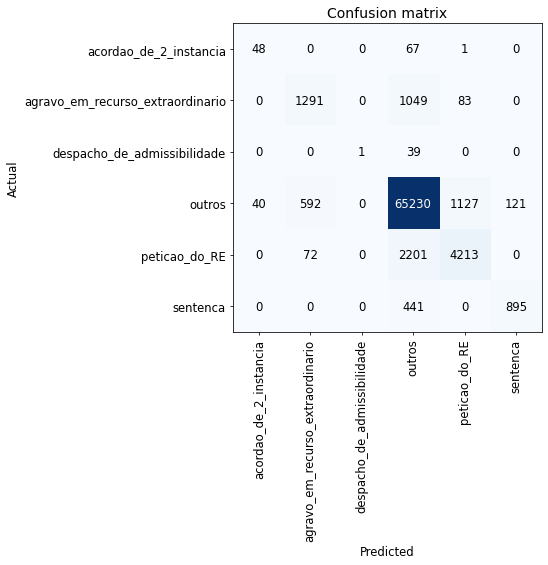

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn.validate()

In [ ]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.5455    0.4138    0.4706       116
agravo_em_recurso_extraordinario     0.6604    0.5328    0.5898      2423
     despacho_de_admissibilidade     1.0000    0.0250    0.0488        40
                          outros     0.9450    0.9720    0.9583     67110
                   peticao_do_RE     0.7767    0.6496    0.7075      6486
                        sentenca     0.8809    0.6699    0.7611      1336

                        accuracy                         0.9247     77511
                       macro avg     0.8014    0.5438    0.5893     77511
                    weighted avg     0.9203    0.9247    0.9212     77511

0.924746165060443


In [ ]:
# create dataloader of test
dblock_test_tags = DataBlock(
    blocks=(TextBlock.from_df('text', seq_len=72), CategoryBlock),
            get_x=get_features,
            get_y=get_labels)

dloader_test_tags = dblock_test_tags.dataloaders(df_test_tags, bs=128)

In [ ]:
test_dl = dloader_test_tags.test_dl(df_test_tags['text'])
preds_tags = learn_tags.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
preds,y,losses = learn_tags.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [ ]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.40448352694511414,0.11115841567516327,0.8888415694236755,1.4985283613204956,0.8718469904215543]

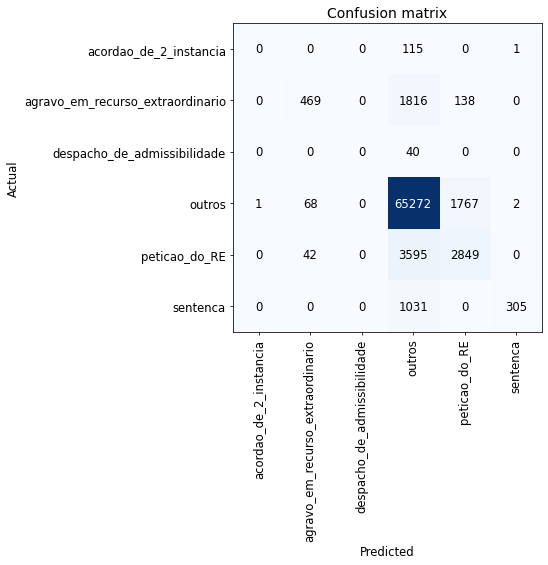

In [ ]:
interp_tags = ClassificationInterpretation.from_learner(learn_tags)
interp_tags.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_tags.validate()

In [ ]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       116
agravo_em_recurso_extraordinario     0.8100    0.1936    0.3125      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.9082    0.9726    0.9393     67110
                   peticao_do_RE     0.5993    0.4393    0.5069      6486
                        sentenca     0.9903    0.2283    0.3710      1336

                        accuracy                         0.8888     77511
                       macro avg     0.5513    0.3056    0.3550     77511
                    weighted avg     0.8789    0.8888    0.8718     77511

0.8888415837752061


## No Gradual Unfreezing


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.222146,0.314919,0.084285,0.915715,1.370148,0.905087,05:17
1,0.336579,1.056948,0.125363,0.874637,2.877574,0.834426,05:17
2,0.262624,nan,0.122408,0.877592,nan,0.834410,05:15
3,0.292141,9.702120,0.345899,0.654101,16352.234375,0.694201,05:15
4,0.250246,30.994217,0.596973,0.403027,28881341906944.000000,0.530675,05:15
5,0.228286,0.909404,0.348828,0.651172,2.482841,0.735681,05:14
6,0.202973,23.631002,0.108165,0.891835,18315296768.000000,0.886918,05:14
7,0.178549,2.044990,0.091458,0.908542,7.729082,0.902565,05:14
8,0.166642,9.599975,0.091819,0.908181,14764.407227,0.904297,05:14
9,0.152920,88.317223,0.098915,0.901085,226820559639560257596441712959917391872.000000,0.902102,05:14


Better model found at epoch 0 with valid_loss value: 0.3149186372756958.


SuggestedLRs(valley=0.0030199517495930195)

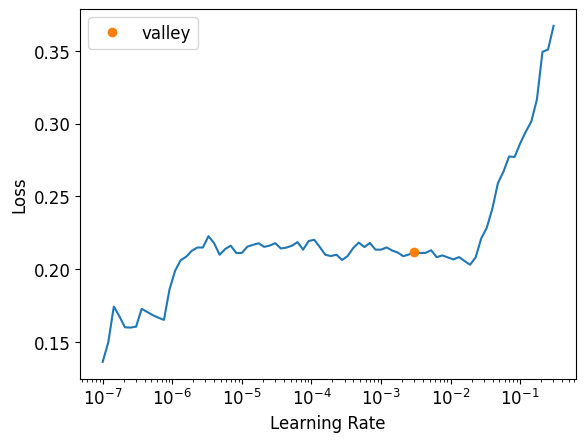

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

(#5) [0.3149186372756958,0.08428481221199036,0.915715217590332,1.3701478242874146,0.9050874525885177]

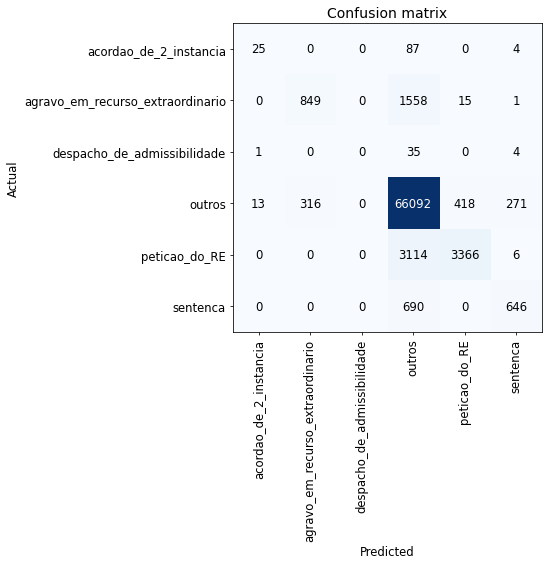

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn.validate()

In [ ]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.6410    0.2155    0.3226       116
agravo_em_recurso_extraordinario     0.7288    0.3504    0.4732      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.9234    0.9848    0.9531     67110
                   peticao_do_RE     0.8860    0.5190    0.6545      6486
                        sentenca     0.6931    0.4835    0.5697      1336

                        accuracy                         0.9157     77511
                       macro avg     0.6454    0.4255    0.4955     77511
                    weighted avg     0.9093    0.9157    0.9051     77511

0.9157151888119106


In [ ]:
learn_tags.unfreeze()
learn_tags.fit_one_cycle(10, 1e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.252233,0.414901,0.100437,0.899563,1.514221,0.873226,06:08
1,0.249972,0.440573,0.106566,0.893434,1.553596,0.862151,06:08
2,0.288879,2.213814,0.134187,0.865813,9.150548,0.803544,06:07
3,0.268946,nan,0.134187,0.865813,nan,0.803544,06:06
4,0.271967,0.574137,0.130523,0.869477,1.775597,0.815927,06:05
5,0.233340,0.576848,0.126072,0.873928,1.780417,0.828564,06:03
6,0.228656,0.555921,0.139051,0.860949,1.743546,0.822048,06:01
7,0.199314,0.392980,0.118048,0.881952,1.481389,0.852950,06:01
8,0.191293,0.465723,0.114216,0.885784,1.593166,0.865301,06:02
9,0.180504,0.410774,0.124124,0.875876,1.507985,0.833629,06:01


Better model found at epoch 0 with valid_loss value: 0.4149010181427002.
Better model found at epoch 7 with valid_loss value: 0.3929799795150757.


In [ ]:
test_dl = dloader_test_tags.test_dl(df_test_tags['text'])
preds_tags = learn_tags.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
preds,y,losses = learn_tags.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [ ]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.3929799795150757,0.11804775893688202,0.8819522261619568,1.4813886880874634,0.852950332715129]

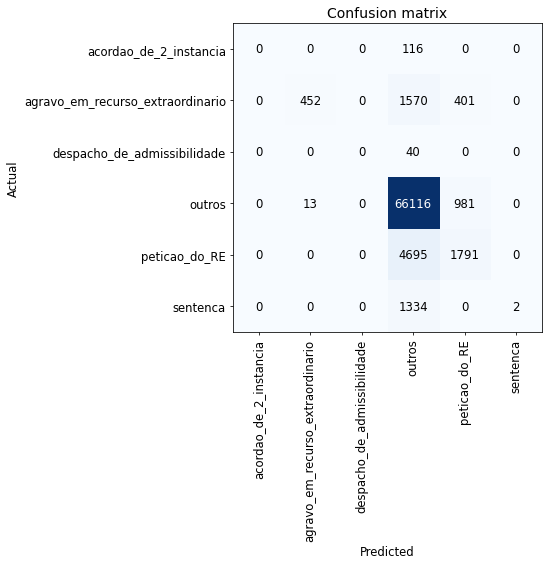

In [ ]:
interp_tags = ClassificationInterpretation.from_learner(learn_tags)
interp_tags.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_tags.validate()

In [ ]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       116
agravo_em_recurso_extraordinario     0.9720    0.1865    0.3130      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.8950    0.9852    0.9379     67110
                   peticao_do_RE     0.5645    0.2761    0.3708      6486
                        sentenca     1.0000    0.0015    0.0030      1336

                        accuracy                         0.8820     77511
                       macro avg     0.5719    0.2416    0.2708     77511
                    weighted avg     0.8698    0.8820    0.8530     77511

0.8819522390370399


## Other Fine-tune LM

In [ ]:
learn_lm = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5,metrics=[error_rate, accuracy, Perplexity(),f1]).to_fp16()

In [ ]:
learn_lm.fine_tune(15, 1e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.451026,0.445149,0.133297,0.866703,1.560722,0.849554,02:54


Better model found at epoch 0 with valid_loss value: 0.4451488256454468.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.311039,0.349894,0.095341,0.904659,1.418917,0.896219,05:14
1,0.277309,0.321509,0.085820,0.914180,1.379207,0.906212,05:14
2,0.244530,0.324709,0.081485,0.918515,1.383628,0.912200,05:15
3,0.207956,0.300013,0.078311,0.921689,1.349876,0.916346,05:14
4,0.185311,0.304151,0.077576,0.922424,1.355474,0.917168,05:14
5,0.163255,0.293775,0.072648,0.927352,1.341482,0.922028,05:14
6,0.146909,0.319043,0.072016,0.927984,1.375810,0.924174,05:14
7,0.125357,0.298530,0.069564,0.930436,1.347877,0.927096,05:14
8,0.119625,0.322707,0.067861,0.932139,1.380860,0.930531,05:14
9,0.103852,0.311622,0.070622,0.929378,1.365638,0.928554,05:14


Better model found at epoch 0 with valid_loss value: 0.3498942255973816.
Better model found at epoch 1 with valid_loss value: 0.32150906324386597.
Better model found at epoch 3 with valid_loss value: 0.3000129759311676.
Better model found at epoch 5 with valid_loss value: 0.29377466440200806.


In [ ]:
learn_lm.save('model_lm_notfirst_'+ now)

Path('models/model_tags_notfirst_2023-07-21-11:43:30.pth')

In [ ]:
# load model
learn_lm = learn_lm.load('model_lm_notfirst_'+ now)

In [ ]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn_lm.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
preds,y,losses = learn_lm.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [ ]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.29377466440200806,0.07264775037765503,0.927352249622345,1.3414815664291382,0.9220281022237813]

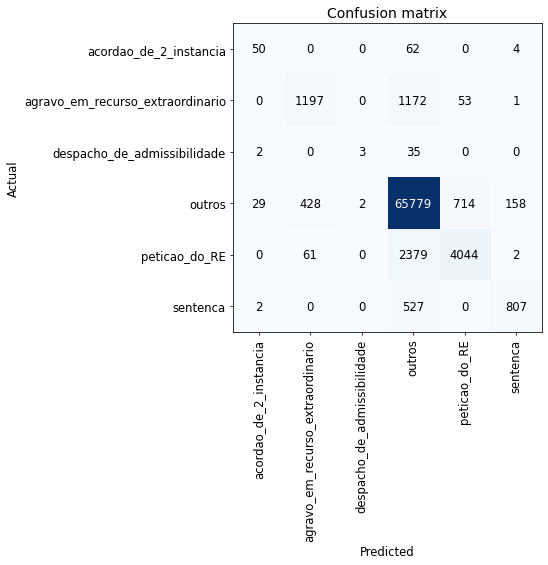

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_lm)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_lm.validate()

In [ ]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.6024    0.4310    0.5025       116
agravo_em_recurso_extraordinario     0.7100    0.4940    0.5826      2423
     despacho_de_admissibilidade     0.6000    0.0750    0.1333        40
                          outros     0.9403    0.9802    0.9598     67110
                   peticao_do_RE     0.8406    0.6235    0.7159      6486
                        sentenca     0.8302    0.6040    0.6993      1336

                        accuracy                         0.9274     77511
                       macro avg     0.7539    0.5346    0.5989     77511
                    weighted avg     0.9222    0.9274    0.9220     77511

0.9273522467778766


In [ ]:
learn_tags_lm = text_classifier_learner(dls_nf, AWD_LSTM, drop_mult=0.5,metrics=[error_rate, accuracy, Perplexity(),f1]).to_fp16()


In [ ]:
learn_tags_lm.fine_tune(10, 1e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.433472,0.455014,0.132923,0.867077,1.576196,0.810341,03:17


Better model found at epoch 0 with valid_loss value: 0.45501428842544556.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.323508,0.397436,0.124099,0.875901,1.488005,0.854507,06:06
1,0.285439,0.365532,0.107985,0.892015,1.441281,0.866662,06:06
2,0.242566,0.374237,0.112126,0.887874,1.453881,0.862749,06:05
3,0.197647,0.379133,0.110152,0.889848,1.461017,0.865620,06:06
4,0.177381,0.481097,0.107004,0.892996,1.617849,0.871624,06:06
5,0.142295,0.448345,0.102798,0.897202,1.565719,0.880158,06:06
6,0.133696,0.506281,0.099973,0.900027,1.659109,0.882761,06:06
7,0.108527,0.574135,0.098992,0.901008,1.775594,0.883221,06:05
8,0.098771,0.591300,0.099250,0.900750,1.806334,0.881892,06:05
9,0.100403,0.549499,0.099973,0.900027,1.732386,0.882630,06:05


Better model found at epoch 0 with valid_loss value: 0.39743632078170776.
Better model found at epoch 1 with valid_loss value: 0.3655323386192322.


In [ ]:
learn_tags_lm.save('model_tags_first_nf_'+ now)

Path('models/model_tags_first_nf_2023-07-21-11:43:30.pth')

In [ ]:
# load model
learn_tags_lm = learn_tags_lm.load('model_tags_first_nf_'+ now)

In [ ]:
test_dl = dloader_test_tags.test_dl(df_test['text'])
preds_tags_lm = learn_tags_lm.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
preds,y,losses = learn_tags_lm.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [ ]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.3655323386192322,0.10798466950654984,0.8920153379440308,1.4412810802459717,0.8666615246194928]

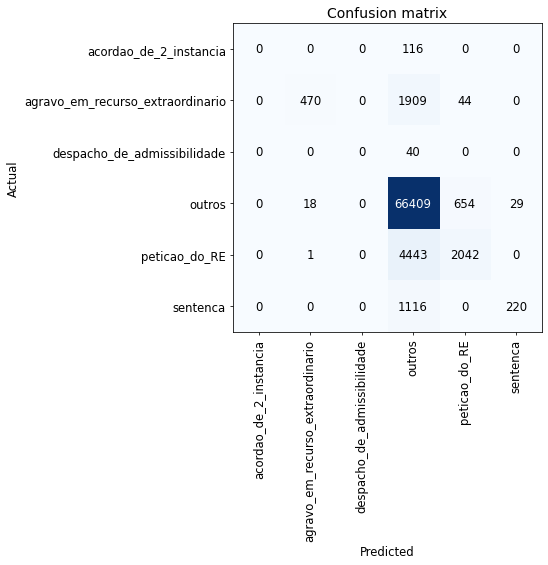

In [ ]:
interp_tags_lm = ClassificationInterpretation.from_learner(learn_tags_lm)
interp_tags_lm.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_tags_lm.validate()

In [ ]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       116
agravo_em_recurso_extraordinario     0.9611    0.1940    0.3228      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.8970    0.9896    0.9410     67110
                   peticao_do_RE     0.7453    0.3148    0.4427      6486
                        sentenca     0.8835    0.1647    0.2776      1336

                        accuracy                         0.8920     77511
                       macro avg     0.5812    0.2772    0.3307     77511
                    weighted avg     0.8843    0.8920    0.8667     77511

0.8920153268568333
